In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error as mae, mean_squared_error as mse
from sklearn.metrics import accuracy_score

import scipy.stats as sts

from collections import Counter

import matplotlib.pyplot as plt
plt.style.use('ggplot')

from keras.utils import np_utils
%matplotlib inline

np.random.seed(777)

Using TensorFlow backend.


## Байесовский подход к классификации

**Задача:**
по известным плотностям распределения $p_y(x)$ и априорным вероятностям
$P_y$ всех классов $y\in Y$ построить алгоритм $a(x)$, минимизирующий вероятность
ошибочной классификации.

Пусть $X\in R_n$ ($R_n$- евклидово пространство столбцов высоты $n$) — множество объектов, $Y \in \{1,...,m\}$, $m\in \mathbb{N}$, — конечное множество имён классов, множество
$X × Y$ является вероятностным пространством с плотностью распределения
$p(x,y) = P(y)p(x|y)$. Вероятности появления объектов каждого из классов
$P_y = P(y)$ называются априорными вероятностями классов. Плотности распределения
$p_y(x) = p(x|y)$ называются функциями правдоподобия классов*.


$R_n = X_1 \cup ... \cup X_m$,$\,\,\,\,\,$ $X_i ∩ X_j=∅,i \ne j,\,\,\, i,j=\overline{1,m}$ (условие независимости).

**Решение.**

Будем предполагать, что классы равнозначны.

Очевидно, что оптимальный алгоритм примет вид:
$$a(x) = argmax_{i\in{1,...,m}} P(y=i|x)$$

По теореме Байеса получим: 

$$P(y=i|x) = \frac{p(x|y=i)P(y=i)}{p(x)}$$

По формуле полной вероятности:
$$p(x)=\sum\limits_{i=1}^{m}p(x|y=i)P(y=i)$$


*Большой буквой $P$ будем обозначать вероятности, а строчной $p$ — плотности распределения.

### Вычислительный эксперимент.

Пусть $X_i$ ~ $N(\mu_i,\Sigma_i)$, $i=\overline{1,m}$.

Плотность нормального распределения:
$$f(x) = \frac{1}{\sqrt{(2 \pi)^n \det \Sigma}}
       \exp\left( -\frac{1}{2} (x - \mu)^T \Sigma^{-1} (x - \mu) \right).$$
       
Для $X_i ∩ X_j=∅,i \ne j,\,\,\, i,j=\overline{1,m}$ (условие независимости сл. вел) **iff** недиоганальные элементы соответствующих матриц ковариаций ($\Sigma_i$) равны нулю.


Сначала для простоты рассмотрим 1D-случай. Пусть имеем 3 класса объектов.

In [2]:
#Гиперпараметры эксперимента
n = 1 
m = 3

SIZE=10000

#зададим априорные вероятности всех классов
prior_class_proba = dict()
prior_class_proba[0]=0.6
prior_class_proba[1]=0.3
prior_class_proba[2]=0.1

#зададим параметры известных плотностей распределения p(x|t). В качестве p(x|t)  
class_likelihood = dict()
for i in range(m):
    class_likelihood[i]={}
class_likelihood[0]["mean"] = 2.5
class_likelihood[0]["cov"] = 2.5
class_likelihood[1]["mean"] = 0
class_likelihood[1]["cov"] = 0.25
class_likelihood[2]["mean"] = 5.5
class_likelihood[2]["cov"] = 5.5

In [3]:
def joint_proba_dist(x,y):
    """
    return: p(x,y)=P(y)p(x|y)
    """
    y = int(y)
    # зададим нормально распределенную случайную величину
    norm_rv = sts.multivariate_normal(**class_likelihood[y])
    
    return prior_class_proba[y]*norm_rv.pdf(x)

In [4]:
x = np.linspace(-10, 10, 10000)

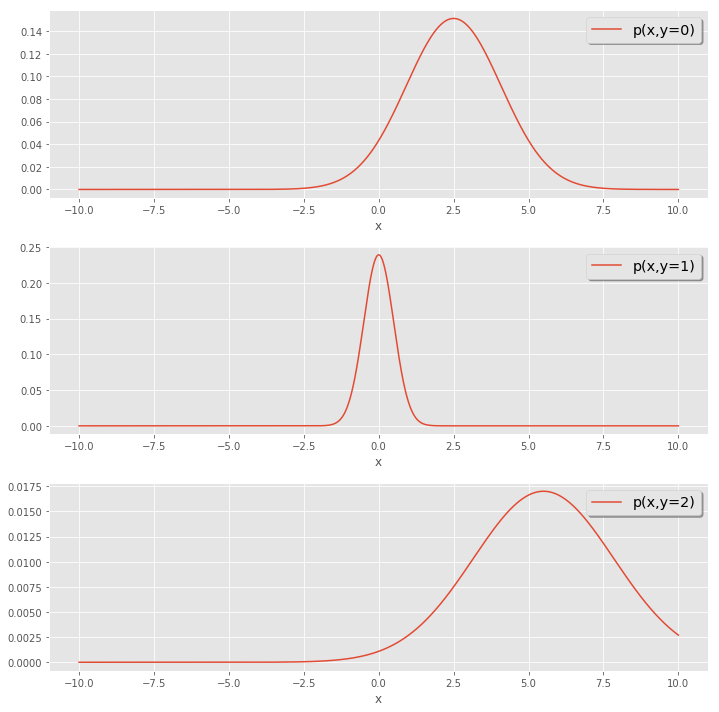

In [5]:
# Построим графики зависимости p(x,y=1), p(x,y=2), p(x,y=3)
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 10));
for i in range(3):
    axes[i].plot(x, joint_proba_dist(x,y=i),label='p(x,y={})'.format(i))
    axes[i].set_xlabel("x")
    axes[i].legend(loc='upper right', shadow=True, fontsize='x-large')
        
fig.tight_layout()

### Генерация обучающей выборки.


In [6]:
#генерация выборки
def data_sampling(m,size):
    """
    p(x,y)=p(x|y)P(y) --> {(x_k, y_k), k = 1,...,size}
    """
    Y = np.random.choice(np.array(range(m)), p=[prior_class_proba[i] for i in range(m)],size=size)
    X=[]
    for y in Y:
        y=int(y)
        # зададим нормально распределенную случайную величину
        norm_rv = sts.multivariate_normal(**class_likelihood[y])
    
        # генерируем x|y
        X.append(norm_rv.rvs(size=1))
        
    X = np.array(X)  
    return X,Y
    

In [7]:
X,Y = data_sampling(m,size=SIZE)

In [8]:
Counter(Y) 

Counter({0: 6036, 1: 3001, 2: 963})

In [9]:
Xtr, Xval, ytr, yval = train_test_split(X,Y,test_size=0.25,shuffle=True)

In [10]:
Xval.shape

(2500,)

### Расчёт апостериорных вероятностей классов

In [11]:
def posterior_proba(x,y,m):
    """
    calculate p(y|x) by Bayes' theorem
    """
    y = int(y)
    prior_proba = prior_class_proba[y]
    likelihood = sts.multivariate_normal(**class_likelihood[y]).pdf(x)
    evidence = np.sum([sts.multivariate_normal(**class_likelihood[i]).pdf(x)*prior_class_proba[i] for i in range(m)])
    posterior_proba = prior_proba*likelihood/evidence
    
    return posterior_proba
    

In [12]:
b_proba_tr = np.zeros((Xtr.shape[0],m))
b_proba_val = np.zeros((Xval.shape[0],m))

#непосредственный расчёт 
for i in range(Xtr.shape[0]):
    for j in range(m):
        b_proba_tr[i][j]=posterior_proba(Xtr.reshape(-1, 1)[i],j,m)

#непосредственный расчёт 
for i in range(Xval.shape[0]):
    for j in range(m):
        b_proba_val[i][j]=posterior_proba(Xval.reshape(-1, 1)[i],j,m)

Посчитаем долю правильных ответов, сделанных в байесовской постановке:

In [13]:
ytr_ = np_utils.to_categorical(ytr, m)
yval_ = np_utils.to_categorical(yval, m)
print("At train set:")
print(accuracy_score(np.argmax(ytr_,axis=1),np.argmax(b_proba_tr,axis=1)))
print("At valid set:")
print(accuracy_score(np.argmax(yval_,axis=1),np.argmax(b_proba_val,axis=1)))

At train set:
0.8361333333333333
At valid set:
0.8424


**Построим графики апостериорных вероятностией классов**

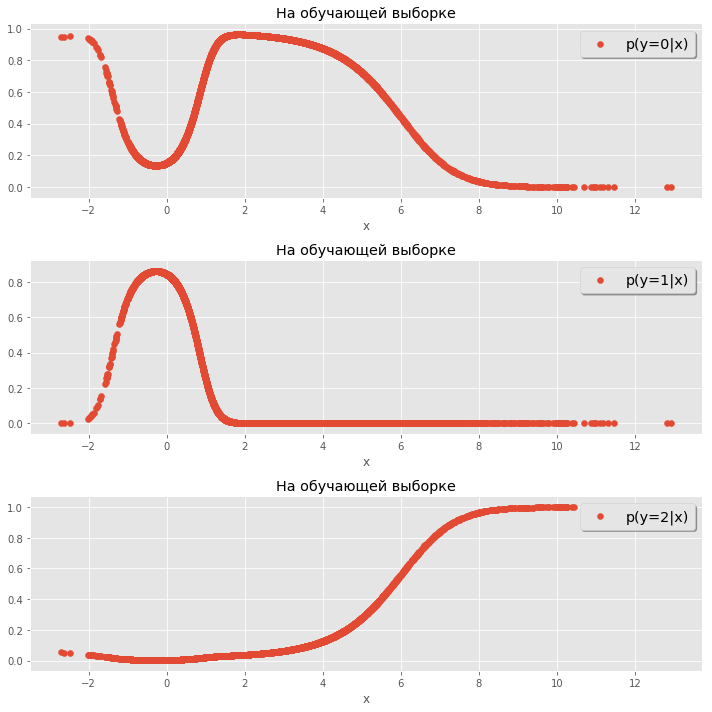

In [14]:
fig, axes = plt.subplots(nrows=m, ncols=1, figsize=(10, 10));
for i in range(m):
    axes[i].scatter(Xtr.reshape(-1, 1), b_proba_tr[:,i],label='p(y={}|x)'.format(i))
    axes[i].set_xlabel("x")
    axes[i].legend(loc='upper right', shadow=True, fontsize='x-large')
    axes[i].set_title("На обучающей выборке")   
fig.tight_layout()

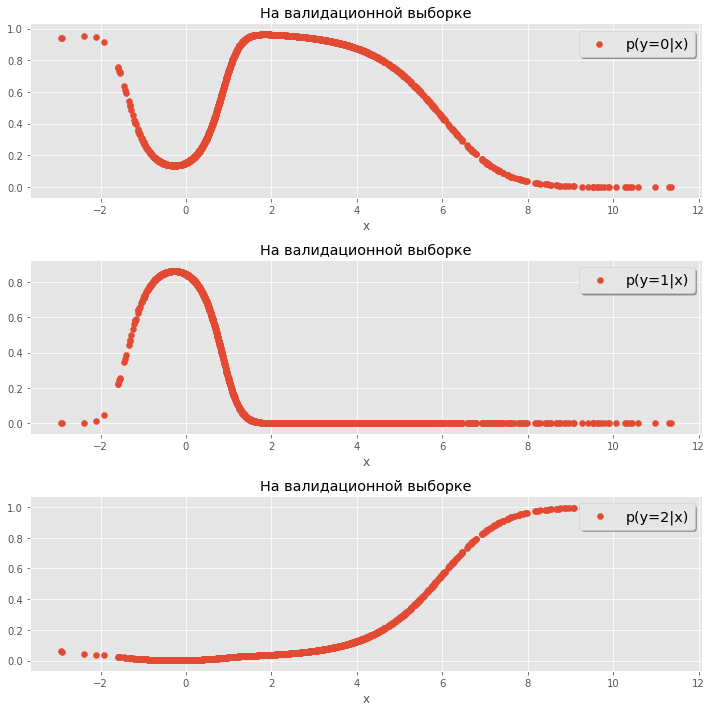

In [15]:
fig, axes = plt.subplots(nrows=m, ncols=1, figsize=(10, 10));
for i in range(m):
    axes[i].scatter(Xval.reshape(-1, 1), b_proba_val[:,i],label='p(y={}|x)'.format(i))
    axes[i].set_xlabel("x")
    axes[i].legend(loc='upper right', shadow=True, fontsize='x-large')
    axes[i].set_title("На валидационной выборке")   
fig.tight_layout()

## ИНС

In [16]:
#for training NN
SS = StandardScaler()
SS.fit(Xtr.reshape(-1, 1))
Xtr_scaled = SS.transform(Xtr.reshape(-1, 1))
Xval_scaled = SS.transform(Xval.reshape(-1, 1))

In [17]:
Xtr_scaled.shape, Xval_scaled.shape

((7500, 1), (2500, 1))

In [18]:
class NeuralNetwork:    
    
    def __init__(self, num_features, hidden_size, seed=None):
        self.num_features = num_features
        self.hidden_size = hidden_size
        self.init_weights(seed)
    
    def init_weights(self, seed):
        np.random.seed(seed)
        self.W1 = np.random.normal(size=(self.num_features, self.hidden_size), scale=0.1)
        self.b1 = np.random.normal(size=self.hidden_size)
        
        self.W2 = np.random.normal(size=(self.hidden_size, 1), scale=0.1)
        self.b2 = np.random.normal(size=1)
    
    def relu(self, x):
        return np.maximum(x, 0)
    
    def sigmoid(self,x):
        return 1 / (1 + np.exp(-x))
    
    def relu_grad(self, x):
        return np.where(x > 0, 1, 0)
    
    def predict(self, X):
        hidden = self.relu(np.dot(X, self.W1) + self.b1)
        return  self.sigmoid(np.dot(hidden, self.W2) + self.b2)
    
    def loss(self, X, y):
        return np.sum(np.square((self.predict(X) - y)))/2/len(y)
    
    def loss_gradient(self, X, y):
        hidden = np.dot(X, self.W1) + self.b1
        activation = self.relu(hidden)
        answer = np.dot(activation, self.W2) + self.b2
        
        error = answer - y
        
        db2 = (error).sum()/len(y)
        dW2 = activation.T.dot(error)/len(y)
        
        dhidden = self.relu_grad(hidden) * error * self.W2.T
        db1 = dhidden.mean(0)
        dW1 = Xtr_scaled.T.dot(dhidden/len(ytr))
        
        return dW1, db1, dW2, db2
    
    def gradient_descent(self, X, y, learning_rate):
        dW1, db1, dW2, db2 = self.loss_gradient(X, y)
        
        self.W1 -= dW1 * learning_rate
        self.b1 -= db1 * learning_rate
        
        self.W2 -= dW2 * learning_rate
        self.b2 -= db2 * learning_rate
        
    def fit(self, X, y, epochs, learning_rate, validation_data):
        losses = []
        val_losses = []
        Xval, yval = validation_data
        for epoch in range(epochs):
            if not (epoch + 1) % 100:
                print('Epoch {} started'.format(epoch + 1))
            self.gradient_descent(X, y, learning_rate)
            losses.append(self.loss(X, y))
            val_losses.append(self.loss(Xval, yval))
        return np.array(losses), np.array(val_losses)

In [19]:
def plot_losses(losses, val_losses, xscale=None, yscale=None,i=-1):
    plt.plot(range(1, len(losses) + 1), losses)
    plt.plot(range(1, len(losses) + 1), val_losses)
    plt.legend(['Train', 'Validation'])
    if i!=-1:
        plt.title('Training history_{}'.format(i))
    else:
        plt.title('Training history')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    if xscale:
        plt.xscale(xscale)
    if yscale:
        plt.yscale(yscale)

In [20]:
def accuracy_report(y_true, y_pred, make_plot=True):
    print('MSE: {:.3f}'.format(mse(y_true, y_pred)))
    print('MAE: {:.3f}'.format(mae(y_true, y_pred)))
    if make_plot:
        plt.scatter(y_true, y_pred)
        plt.xlabel('Reality')
        plt.ylabel('Prediction')
        plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], '--')

### Обучаем и совершаем предсказания

CLASS_0
Epoch 100 started
Epoch 200 started
Epoch 300 started
Epoch 400 started
Epoch 500 started
TRAIN
MSE: 0.201
MAE: 0.426
VALID
MSE: 0.199
MAE: 0.423

CLASS_1
Epoch 100 started
Epoch 200 started
Epoch 300 started
Epoch 400 started
Epoch 500 started
TRAIN
MSE: 0.234
MAE: 0.473
VALID
MSE: 0.235
MAE: 0.473

CLASS_2
Epoch 100 started
Epoch 200 started
Epoch 300 started
Epoch 400 started
Epoch 500 started
TRAIN
MSE: 0.256
MAE: 0.504
VALID
MSE: 0.256
MAE: 0.504



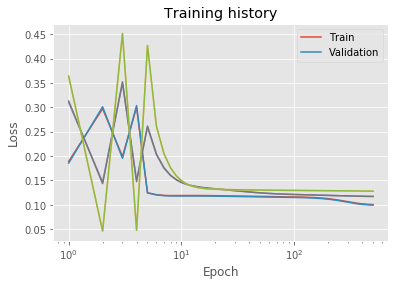

In [21]:
hat_proba_preds_tr = np.zeros((Xtr_scaled.shape[0],m))
hat_proba_preds_val = np.zeros((Xval_scaled.shape[0],m))

for i in range(m):
    print("CLASS_{}".format(i))
    nn = NeuralNetwork(Xtr_scaled.shape[1], hidden_size=64, seed=777)
    losses, val_losses = nn.fit(Xtr_scaled, ytr_[:,i].reshape(-1,1),
                            epochs=500, learning_rate=0.1,
                            validation_data=(Xval_scaled, yval_[:,i].reshape(-1,1)))
    print("TRAIN")
    accuracy_report(ytr_[:,i].reshape(-1,1), nn.predict(Xtr_scaled), make_plot=False)
    hat_proba_preds_tr[:,i]=nn.predict(Xtr_scaled).reshape(1,-1)[0]
    
    print("VALID")
    accuracy_report(yval_[:,i].reshape(-1,1), nn.predict(Xval_scaled), make_plot=False)
    plot_losses(losses, val_losses, xscale='log')
    hat_proba_preds_val[:,i]=nn.predict(Xval_scaled).reshape(1,-1)[0]
    
    print()

Посчитаем долю правильных ответов, сделанных ИНС:

In [22]:
print("At train set:")
print(accuracy_score(np.argmax(ytr_,axis=1),np.argmax(hat_proba_preds_tr,axis=1)))
print("At valid set:")
print(accuracy_score(np.argmax(yval_,axis=1),np.argmax(hat_proba_preds_val,axis=1)))

At train set:
0.8334666666666667
At valid set:
0.8312


In [23]:
hat_proba_preds_tr

array([[0.68995431, 0.49229166, 0.55087297],
       [0.65273504, 0.49121043, 0.59030642],
       [0.65893438, 0.490906  , 0.58405845],
       ...,
       [0.6704738 , 0.56768802, 0.50476612],
       [0.72971052, 0.49906688, 0.51494596],
       [0.73211737, 0.50226694, 0.5117587 ]])

# Сравнение "вероятностей" классов, предсказываемых  ИНС, с апостериорными вероятностями классов.

Посмотрим как сеть аппроксимируют апостериорные вероятности классов.

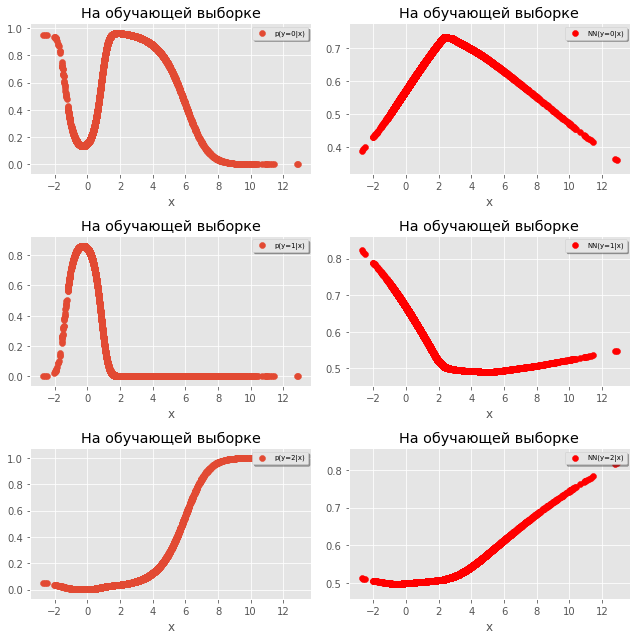

In [24]:
fig, axes = plt.subplots(nrows=m, ncols=2, figsize=(9, 9));
for i in range(m):
    axes[i][0].scatter(Xtr.reshape(-1, 1), b_proba_tr[:,i],label='p(y={}|x)'.format(i))
    axes[i][0].set_xlabel("x")
    axes[i][0].legend(loc='upper right', shadow=True, fontsize='x-small')
    axes[i][0].set_title("На обучающей выборке")
    axes[i][1].scatter(Xtr.reshape(-1, 1), hat_proba_preds_tr[:,i],label='NN(y={}|x)'.format(i),color="r")
    axes[i][1].set_xlabel("x")
    axes[i][1].legend(loc='upper right', shadow=True, fontsize='x-small')
    axes[i][1].set_title("На обучающей выборке") 
fig.tight_layout()

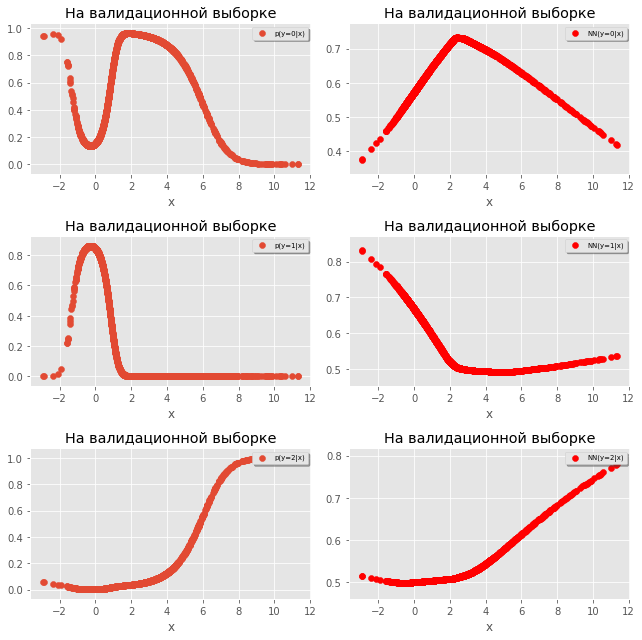

In [25]:
fig, axes = plt.subplots(nrows=m, ncols=2, figsize=(9, 9));
for i in range(m):
    axes[i][0].scatter(Xval.reshape(-1, 1), b_proba_val[:,i],label='p(y={}|x)'.format(i))
    axes[i][0].set_xlabel("x")
    axes[i][0].legend(loc='upper right', shadow=True, fontsize='x-small')
    axes[i][0].set_title("На валидационной выборке")
    axes[i][1].scatter(Xval.reshape(-1, 1), hat_proba_preds_val[:,i],label='NN(y={}|x)'.format(i),color="r")
    axes[i][1].set_xlabel("x")
    axes[i][1].legend(loc='upper right', shadow=True, fontsize='x-small')
    axes[i][1].set_title("На валидационной выборке") 
fig.tight_layout()

Приведём ещё раз долю правильных ответов, сделанных в байесовской постановке:

In [26]:
print("At train set:")
print(accuracy_score(np.argmax(ytr_,axis=1),np.argmax(b_proba_tr,axis=1)))
print("At valid set:")
print(accuracy_score(np.argmax(yval_,axis=1),np.argmax(b_proba_val,axis=1)))

At train set:
0.8361333333333333
At valid set:
0.8424


Приведём ещё раз долю правильных ответов, сделанных ИНС:

In [27]:
print("At train set:")
print(accuracy_score(np.argmax(ytr_,axis=1),np.argmax(hat_proba_preds_tr,axis=1)))
print("At valid set:")
print(accuracy_score(np.argmax(yval_,axis=1),np.argmax(hat_proba_preds_val,axis=1)))

At train set:
0.8334666666666667
At valid set:
0.8312


Сравним распределения вероятностей предсказанных классов (для ИНС имеется в виду "вероятностей" классов) на обучающей выборки.

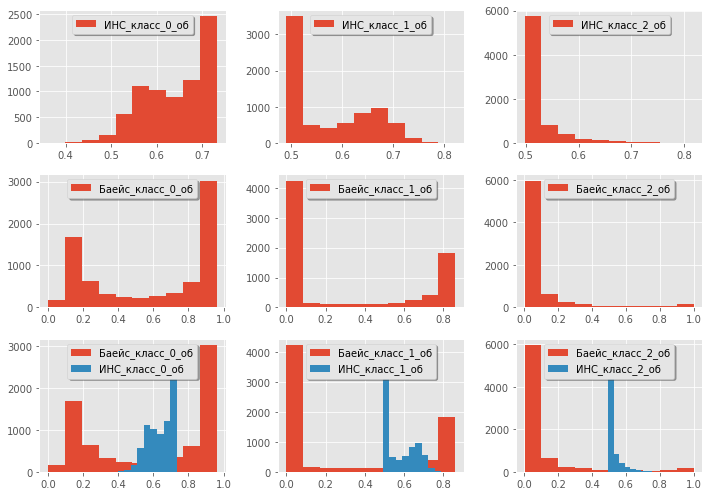

In [28]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10, 7));

for i in range(m):
    axes[0][i].hist(hat_proba_preds_tr[:,i],label='ИНС_класс_{}_об'.format(i))
    axes[0][i].legend(loc='upper center', shadow=True)

for i in range(m):
    axes[1][i].hist(b_proba_tr[:,i],label='Баейс_класс_{}_об'.format(i))
    axes[1][i].legend(loc='upper center', shadow=True)

for i in range(m):
    axes[2][i].hist(b_proba_tr[:,i],label='Баейс_класс_{}_об'.format(i))
    axes[2][i].hist(hat_proba_preds_tr[:,i],label='ИНС_класс_{}_об'.format(i))
    axes[2][i].legend(loc='upper center', shadow=True)

    
fig.tight_layout();

Сравним распределения вероятностей (для ИНС имеется в виду "вероятностей") на валидационной выборки.

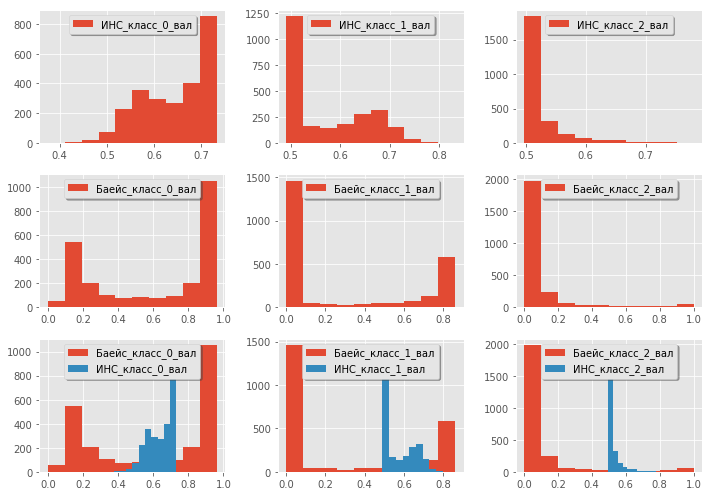

In [29]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10, 7));

for i in range(m):
    axes[0][i].hist(hat_proba_preds_val[:,i],label='ИНС_класс_{}_вал'.format(i))
    axes[0][i].legend(loc='upper center', shadow=True)

for i in range(m):
    axes[1][i].hist(b_proba_val[:,i],label='Баейс_класс_{}_вал'.format(i))
    axes[1][i].legend(loc='upper center', shadow=True)

for i in range(m):
    axes[2][i].hist(b_proba_val[:,i],label='Баейс_класс_{}_вал'.format(i))
    axes[2][i].hist(hat_proba_preds_val[:,i],label='ИНС_класс_{}_вал'.format(i))
    axes[2][i].legend(loc='upper center', shadow=True)

    
fig.tight_layout();

### Поклассовые диаграммы рассеяния предсказаний моделей

In [30]:
all_train_predictions = pd.DataFrame(hat_proba_preds_tr)
all_train_predictions.head()

,0,1,2
0,0.689954,0.492292,0.550873
1,0.652735,0.491210,0.590306
2,0.658934,0.490906,0.584058
3,0.576968,0.663031,0.499944
4,0.688910,0.492215,0.551996


In [31]:
all_train_predictions.columns = ['ИНС_класс_{}_tr'.format(i) for i in range(m)]

In [32]:
for i,col in enumerate(['Баейс_класс_{}_tr'.format(i) for i in range(m)]):
    all_train_predictions[col] =b_proba_tr[:,i]

In [33]:
all_train_predictions.head()

,ИНС_класс_0_tr,ИНС_класс_1_tr,ИНС_класс_2_tr,Баейс_класс_0_tr,Баейс_класс_1_tr,Баейс_класс_2_tr
0,0.689954,0.492292,0.550873,0.849257,6.402211e-16,0.150743
1,0.652735,0.491210,0.590306,0.635183,6.001126e-25,0.364817
2,0.658934,0.490906,0.584058,0.679591,1.979178e-23,0.320409
3,0.576968,0.663031,0.499944,0.161724,8.342197e-01,0.004056
4,0.688910,0.492215,0.551996,0.845046,3.596516e-16,0.154954


In [34]:
print(plt.style.available)

['_classic_test', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark-palette', 'seaborn-dark', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'seaborn', 'Solarize_Light2']


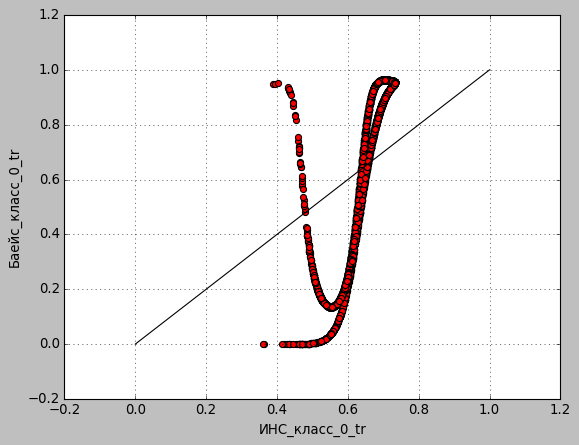

In [35]:
plt.style.use('classic')
all_train_predictions.plot.scatter('ИНС_класс_0_tr', 'Баейс_класс_0_tr', c = 'r', s = 30)
plt.grid()
plt.plot([0,1], c = 'black')


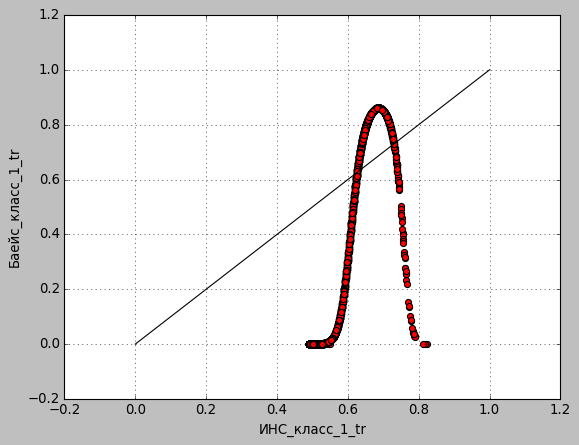

In [36]:
plt.style.use('classic')
all_train_predictions.plot.scatter('ИНС_класс_1_tr', 'Баейс_класс_1_tr', c = 'r', s = 30)
plt.grid()
plt.plot([0,1], c = 'black')


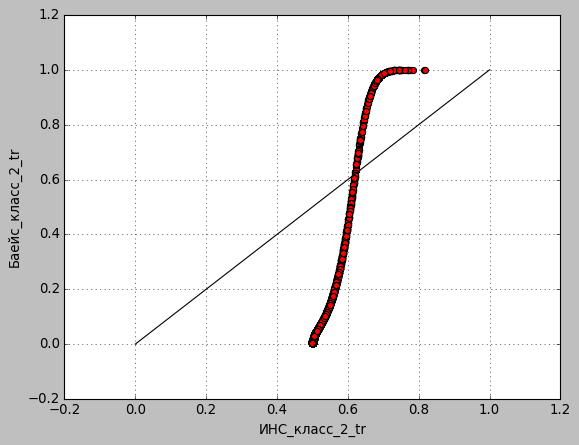

In [37]:
plt.style.use('classic')
all_train_predictions.plot.scatter('ИНС_класс_2_tr', 'Баейс_класс_2_tr', c = 'r', s = 30)
plt.grid()
plt.plot([0,1], c = 'black')


# Многомерный случай

Для определённости рассмотрим 5-мерный случай

In [38]:
#Гиперпараметры эксперимента
n = 5 
m = 3

SIZE=1000

#зададим априорные вероятности всех классов
prior_class_proba = dict()
prior_class_proba[0]=0.45
prior_class_proba[1]=0.25
prior_class_proba[2]=0.3

#зададим параметры известных плотностей распределения p(x|t). В качестве p(x|t)  
class_likelihood = dict()
for i in range(m):
    class_likelihood[i]={}
class_likelihood[0]["mean"] = np.random.randint(low=-20,high=20, size=n)
class_likelihood[0]["cov"] = np.eye(n, dtype=int)*np.random.randint(low=20,high=100, size=n)
class_likelihood[1]["mean"] =np.random.randint(low=-10,high=10, size=n)
class_likelihood[1]["cov"] = np.eye(n, dtype=int)*np.random.randint(low=5,high=50, size=n)*0.2
class_likelihood[2]["mean"] = np.random.randint(low=0,high=5, size=n)
class_likelihood[2]["cov"] = np.eye(n, dtype=int)*np.random.randint(low=10,high=20, size=n)*0.1

In [39]:
X,Y = data_sampling(m,size=SIZE)

In [40]:
X.shape

(1000, 5)

In [41]:
Counter(Y)

Counter({0: 441, 1: 275, 2: 284})

In [42]:
Xtr, Xval, ytr, yval = train_test_split(X,Y,test_size=0.25,shuffle=True)

In [43]:
%%time
b_proba_tr = np.zeros((Xtr.shape[0],m))
b_proba_val = np.zeros((Xval.shape[0],m))

#непосредственный расчёт 
for i in range(Xtr.shape[0]):
    for j in range(m):
        b_proba_tr[i][j]=posterior_proba(Xtr[i],j,m)

#непосредственный расчёт 
for i in range(Xval.shape[0]):
    for j in range(m):
        b_proba_val[i][j]=posterior_proba(Xval[i],j,m)

CPU times: user 2.47 s, sys: 24.5 ms, total: 2.5 s
Wall time: 2.49 s


In [44]:
ytr_ = np_utils.to_categorical(ytr, m)
yval_ = np_utils.to_categorical(yval, m)
print("At train set:")
print(accuracy_score(np.argmax(ytr_,axis=1),np.argmax(b_proba_tr,axis=1)))
print("At valid set:")
print(accuracy_score(np.argmax(yval_,axis=1),np.argmax(b_proba_val,axis=1)))

At train set:
0.9933333333333333
At valid set:
0.992


In [45]:
b_proba_tr

array([[1.00751518e-05, 5.77158265e-03, 9.94218342e-01],
       [1.86541104e-05, 6.68285953e-04, 9.99313060e-01],
       [1.76316812e-05, 9.99982368e-01, 2.15504281e-15],
       ...,
       [2.74769148e-06, 1.37582252e-02, 9.86239027e-01],
       [3.89273068e-06, 1.86380761e-02, 9.81358031e-01],
       [4.58269676e-07, 7.69362895e-04, 9.99230179e-01]])

In [46]:
SS = StandardScaler()
SS.fit(Xtr)
Xtr_scaled = SS.transform(Xtr)
Xval_scaled = SS.transform(Xval)

CLASS_0
Epoch 100 started
Epoch 200 started
Epoch 300 started
Epoch 400 started
Epoch 500 started
TRAIN
MSE: 0.182
MAE: 0.410
VALID
MSE: 0.182
MAE: 0.410

CLASS_1
Epoch 100 started
Epoch 200 started
Epoch 300 started
Epoch 400 started
Epoch 500 started
TRAIN
MSE: 0.222
MAE: 0.460
VALID
MSE: 0.224
MAE: 0.464

CLASS_2
Epoch 100 started
Epoch 200 started
Epoch 300 started
Epoch 400 started
Epoch 500 started
TRAIN
MSE: 0.234
MAE: 0.473
VALID
MSE: 0.235
MAE: 0.474



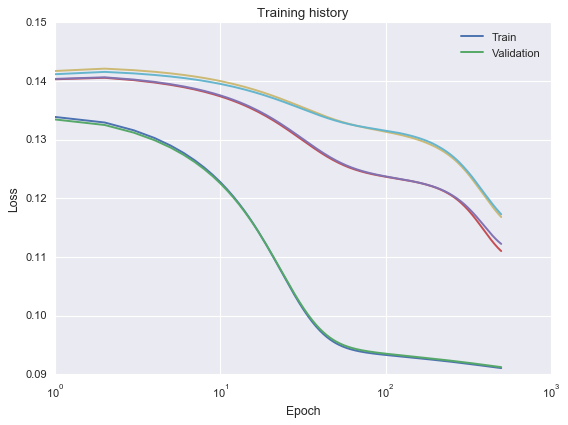

In [47]:
plt.style.use("seaborn")
hat_proba_preds_tr = np.zeros((Xtr_scaled.shape[0],m))
hat_proba_preds_val = np.zeros((Xval_scaled.shape[0],m))

for i in range(m):
    print("CLASS_{}".format(i))
    nn = NeuralNetwork(Xtr_scaled.shape[1], hidden_size=16, seed=777)
    losses, val_losses = nn.fit(Xtr_scaled, ytr_[:,i].reshape(-1,1),
                            epochs=500, learning_rate=0.1,
                            validation_data=(Xval_scaled, yval_[:,i].reshape(-1,1)))
    print("TRAIN")
    accuracy_report(ytr_[:,i].reshape(-1,1), nn.predict(Xtr_scaled), make_plot=False)
    hat_proba_preds_tr[:,i]=nn.predict(Xtr_scaled).reshape(1,-1)[0]
    
    print("VALID")
    accuracy_report(yval_[:,i].reshape(-1,1), nn.predict(Xval_scaled), make_plot=False)
    plot_losses(losses, val_losses, xscale='log')
    hat_proba_preds_val[:,i]=nn.predict(Xval_scaled).reshape(1,-1)[0]
    
    print()

In [48]:
print("At train set:")
print(accuracy_score(np.argmax(ytr_,axis=1),np.argmax(hat_proba_preds_tr,axis=1)))
print("At valid set:")
print(accuracy_score(np.argmax(yval_,axis=1),np.argmax(hat_proba_preds_val,axis=1)))

At train set:
0.964
At valid set:
0.952


In [49]:
all_train_predictions = pd.DataFrame(hat_proba_preds_tr)
all_train_predictions.columns = ['ИНС_класс_{}_tr'.format(i) for i in range(m)]
for i,col in enumerate(['Баейс_класс_{}_tr'.format(i) for i in range(m)]):
    all_train_predictions[col] =b_proba_tr[:,i]
    

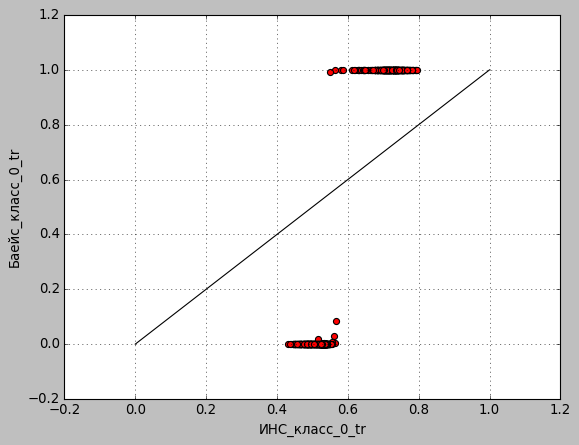

In [50]:
plt.style.use('classic')
all_train_predictions.plot.scatter('ИНС_класс_0_tr', 'Баейс_класс_0_tr', c = 'r', s = 30)
plt.grid()
plt.plot([0,1], c = 'black')

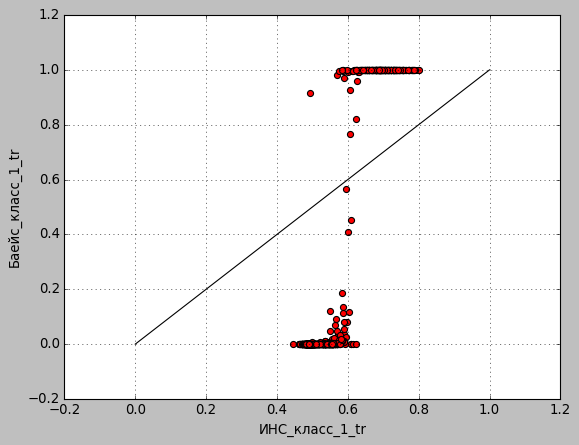

In [51]:
plt.style.use('classic')
all_train_predictions.plot.scatter('ИНС_класс_1_tr', 'Баейс_класс_1_tr', c = 'r', s = 30)
plt.grid()
plt.plot([0,1], c = 'black')


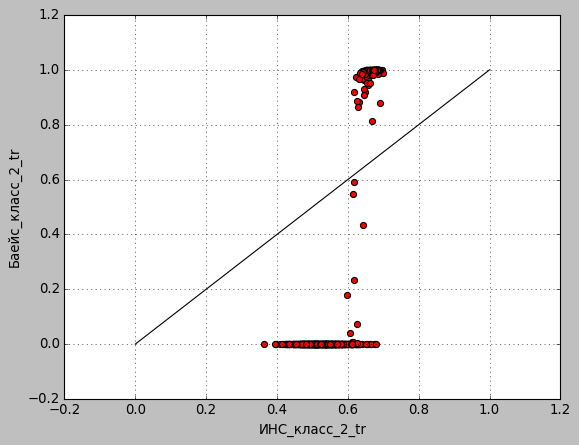

In [52]:
plt.style.use('classic')
all_train_predictions.plot.scatter('ИНС_класс_2_tr', 'Баейс_класс_2_tr', c = 'r', s = 30)
plt.grid()
plt.plot([0,1], c = 'black')
